In [ ]:
!pip install -q torch_geometric

#Cora

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

In [ ]:
dataset = Planetoid(root='/tmp/cora', name='Cora')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

Processing...
Done!


In [ ]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## Node Classification

Processing...
Done!


Ratio: 0.1, AUC: 0.9653
Ratio: 0.2, AUC: 0.9756
Ratio: 0.4, AUC: 0.9822
Ratio: 0.5, AUC: 0.9815


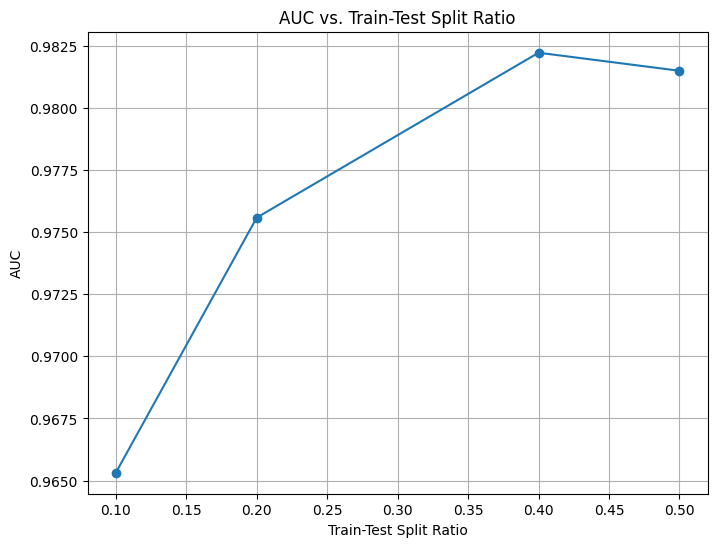

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


dataset = Planetoid(root='/tmp/cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

def train_test_split(data, train_ratio):
    num_nodes = data.num_nodes
    indices = np.random.permutation(num_nodes)
    train_size = int(num_nodes * train_ratio)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_indices] = True
    test_mask[test_indices] = True

    data.train_mask = train_mask
    data.test_mask = test_mask

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    y_true = data.y[data.test_mask].cpu().numpy()
    y_prob = out[data.test_mask].cpu().detach().numpy()

    aucs = []
    for i in range(dataset.num_classes):
        y_true_bin = (y_true == i).astype(int)
        auc = roc_auc_score(y_true_bin, y_prob[:, i])
        aucs.append(auc)
    return np.mean(aucs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ratios = [0.1, 0.2, 0.4, 0.5]
aucs = []

for ratio in ratios:
    model = GCN(hidden_channels=16).to(device)
    data = dataset[0].to(device)
    train_test_split(data, ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(1, 201):
        train()

    auc = test()
    aucs.append(auc)
    print(f'Ratio: {ratio}, AUC: {auc:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(ratios, aucs, marker='o')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('AUC')
plt.title('AUC vs. Train-Test Split Ratio')
plt.grid(True)
plt.show()


## Edge Prediction

Ratio: 0.8, AUC: 0.9655
Ratio: 0.7, AUC: 0.9555
Ratio: 0.6, AUC: 0.9514
Ratio: 0.5, AUC: 0.9342


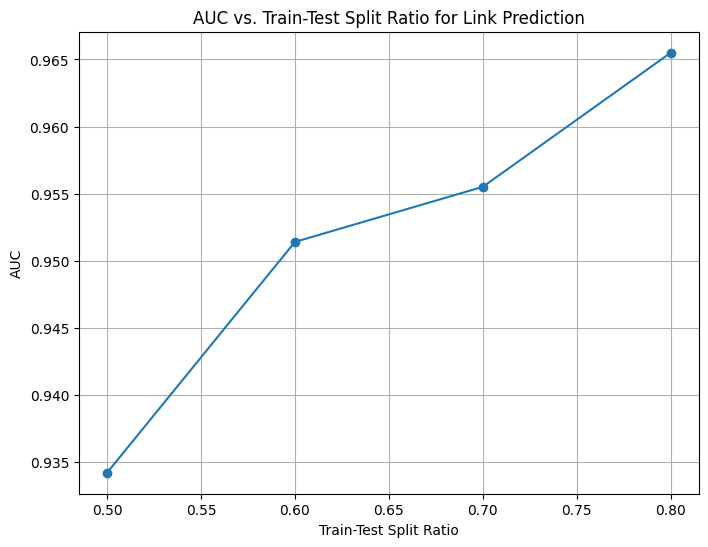

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

dataset = Planetoid(root='/tmp/cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_test_split(data, train_ratio):
    num_nodes = data.num_nodes
    num_edges = data.edge_index.size(1)
    indices = np.random.permutation(num_edges)
    train_size = int(num_edges * train_ratio)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_edge_index = data.edge_index[:, train_indices]
    test_edge_index = data.edge_index[:, test_indices]

    data.train_edge_index = train_edge_index
    data.test_edge_index = test_edge_index

def get_link_labels(pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
    labels = torch.cat([torch.ones(pos_edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim=0)
    return edge_index, labels

def train():
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.train_edge_index)

    pos_edge_index = data.train_edge_index
    neg_edge_index = negative_sampling(pos_edge_index, num_nodes=z.size(0))

    edge_index, link_labels = get_link_labels(pos_edge_index, neg_edge_index)

    link_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.train_edge_index)

        pos_edge_index = data.test_edge_index
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=z.size(0))

        edge_index, link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        link_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        link_probs = link_logits.sigmoid().cpu().numpy()
        link_labels = link_labels.cpu().numpy()

        auc = roc_auc_score(link_labels, link_probs)
    return auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ratios = [0.8, 0.7, 0.6, 0.5]
aucs = []

for ratio in ratios:
    model = GCN(hidden_channels=16).to(device)
    data = dataset[0].to(device)
    train_test_split(data, ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(1, 201):
        train()

    auc = test()
    aucs.append(auc)
    print(f'Ratio: {ratio}, AUC: {auc:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(ratios, aucs, marker='o')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('AUC')
plt.title('AUC vs. Train-Test Split Ratio for Link Prediction')
plt.grid(True)
plt.show()


# Custom Dataset

## Constructing Dataset

You need to upload DANI.txt, cascades.txt, and community.txt files from the sidebar.

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

In [ ]:
with open('/content/DANI.txt', 'r') as file:
    lines = file.readlines()

edges = [line.strip().split(',') for line in lines]
edges_df = pd.DataFrame(edges, columns=['source', 'target'])
edges_df = edges_df.astype(int)
G = nx.from_pandas_edgelist(edges_df, source='source', target='target')

In [ ]:
with open('/content/cascades.txt', 'r') as file:
    lines = file.readlines()

num_nodes = edges_df.to_numpy().max() + 1
num_features = len(lines)

node_features = np.zeros((num_nodes, num_features))
print("Shape of node_features:", node_features.shape)

for j, line in enumerate(lines):
    entries = line.strip().split(';')
    for entry in entries:
        node_id, value = entry.split(',')
        node_id = int(node_id)
        value = float(value)
        node_features[node_id, j] = value

for node_id, features in enumerate(node_features):
    G.nodes[node_id]['x'] = np.array(features, dtype=np.float32)

Shape of node_features: (1000, 20000)


In [ ]:
with open('/content/community.txt', 'r') as file:
    lines = file.readlines()

labels = [list(map(int, l.strip().split())) for l in lines]
print("Number of labels: ", len(labels))
for label, nodes in enumerate(labels):
  for node_id in nodes:
      G.nodes[node_id]['y'] = label


Number of labels:  28


In [ ]:
data = from_networkx(G)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
data

/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  data_dict[key] = torch.as_tensor(value)


Data(x=[1000, 20000], edge_index=[2, 15384], y=[1000])

## Link Prediction

Ratio: 0.99, AUC: 0.7567
Ratio: 0.8, AUC: 0.7335
Ratio: 0.7, AUC: 0.8357
Ratio: 0.6, AUC: 0.7048
Ratio: 0.5, AUC: 0.7057
Ratio: 0.1, AUC: 0.5813


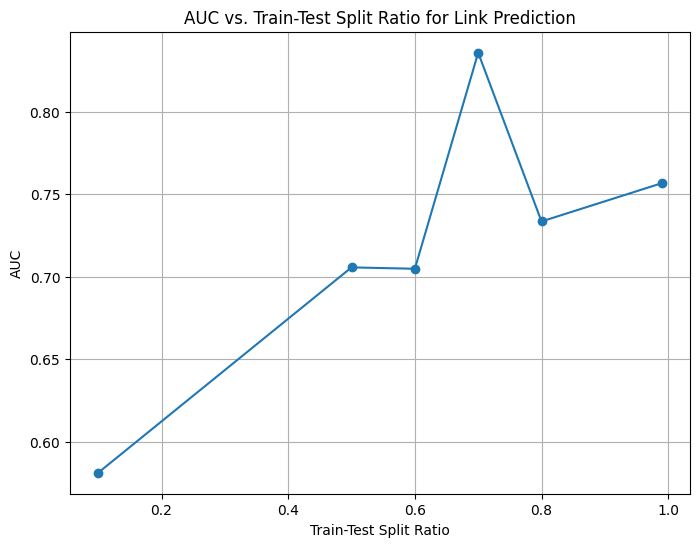

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        return x


def train_test_split(data, train_ratio):
    num_nodes = data.num_nodes
    num_edges = data.edge_index.size(1)
    indices = np.random.permutation(num_edges)
    train_size = int(num_edges * train_ratio)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_edge_index = data.edge_index[:, train_indices]
    test_edge_index = data.edge_index[:, test_indices]

    data.train_edge_index = train_edge_index
    data.test_edge_index = test_edge_index

def get_link_labels(pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1).to(device)
    labels = torch.cat([torch.ones(pos_edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim=0).to(device)
    return edge_index, labels

def train():
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.train_edge_index)

    pos_edge_index = data.train_edge_index
    neg_edge_index = negative_sampling(pos_edge_index, num_nodes=z.size(0))

    edge_index, link_labels = get_link_labels(pos_edge_index, neg_edge_index)

    link_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.train_edge_index)

        pos_edge_index = data.test_edge_index
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=z.size(0))

        edge_index, link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        link_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        link_probs = link_logits.sigmoid().cpu().numpy()
        link_labels = link_labels.cpu().numpy()

        auc = roc_auc_score(link_labels, link_probs)
    return auc


ratios = [0.99, 0.8, 0.7, 0.6, 0.5, 0.1]
aucs = []
highest_auc = 0.0
best_model_state = None

for ratio in ratios:
    model = GCN(num_features=data.x.shape[1], hidden_channels=64).to(device)
    train_test_split(data, ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(1, 201):
        loss = train()

    auc = test()
    aucs.append(auc)
    print(f'Ratio: {ratio}, AUC: {auc:.4f}')

    if auc > highest_auc:
      highest_auc = auc
      best_model_state = model.state_dict()


torch.save({
    'model_state_dict': best_model_state,
}, 'best_gcn_model.pth')

plt.figure(figsize=(8, 6))
plt.plot(ratios, aucs, marker='o')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('AUC')
plt.title('AUC vs. Train-Test Split Ratio for Link Prediction')
plt.grid(True)
plt.show()


Ratio: 0.99, AUC: 0.9409
Ratio: 0.8, AUC: 0.9535
Ratio: 0.7, AUC: 0.9528
Ratio: 0.6, AUC: 0.9531
Ratio: 0.5, AUC: 0.9478
Ratio: 0.1, AUC: 0.7153


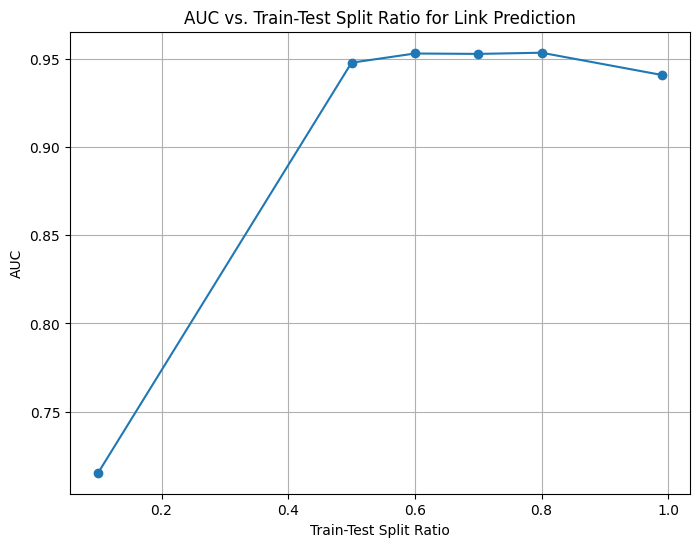

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv4(x, edge_index)
        return x

def train_test_split(data, train_ratio):
    num_edges = data.edge_index.size(1)
    indices = np.random.permutation(num_edges)
    train_size = int(num_edges * train_ratio)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_edge_index = data.edge_index[:, train_indices]
    test_edge_index = data.edge_index[:, test_indices]

    data.train_edge_index = train_edge_index
    data.test_edge_index = test_edge_index

def get_link_labels(pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1).to(device)
    labels = torch.cat([torch.ones(pos_edge_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim=0).to(device)
    return edge_index, labels

def train():
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.train_edge_index)

    pos_edge_index = data.train_edge_index
    neg_edge_index = negative_sampling(pos_edge_index, num_nodes=z.size(0))

    edge_index, link_labels = get_link_labels(pos_edge_index, neg_edge_index)

    link_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.train_edge_index)

        pos_edge_index = data.test_edge_index
        neg_edge_index = negative_sampling(pos_edge_index, num_nodes=z.size(0))

        edge_index, link_labels = get_link_labels(pos_edge_index, neg_edge_index)

        link_logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        link_probs = link_logits.sigmoid().cpu().numpy()
        link_labels = link_labels.cpu().numpy()

        auc = roc_auc_score(link_labels, link_probs)
    return auc


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ratios = [0.99, 0.8, 0.7, 0.6, 0.5, 0.1]
aucs = []
highest_auc = 0.0
best_model_state = None

for ratio in ratios:
    model = GCN(num_features=data.x.shape[1], hidden_channels=128, out_channels=64, dropout=0.5).to(device)
    train_test_split(data, ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(1, 201):
        loss = train()

    auc = test()
    aucs.append(auc)
    print(f'Ratio: {ratio}, AUC: {auc:.4f}')

    if auc > highest_auc:
        highest_auc = auc
        best_model_state = model.state_dict()

torch.save({
    'model_state_dict': best_model_state,
}, 'best_gcn_model.pth')

plt.figure(figsize=(8, 6))
plt.plot(ratios, aucs, marker='o')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('AUC')
plt.title('AUC vs. Train-Test Split Ratio for Link Prediction')
plt.grid(True)
plt.show()
